### Import packages for the simulation

In [2]:
# Normal staple packages
import sys, os
import numpy as np
from numpy import pi as pi, sin as sin, cos as cos, tan as tan, arctan as arctan, arccos as arccos, arcsin as arcsin, exp as exp, log as log, sqrt as sqrt
%matplotlib inline 
# notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


import scipy.io as sio
import copy

# Bloch simulator 
from bloch.bloch import bloch
from bloch.min_time_gradient import minimum_time_gradient

# Biot Savart
sys.path.append('biot-savart-master')
import biot_savart_v4_3 as bs

### Define the grid of spins for our simulation. 

In [3]:
class SpinGrid:
    height = 10 # height of the grid in cm 
    width = 10 # width of the grid in cm
    depth = 10 # z-depth of the grid in cm 
    flow_rate = 5 # flow rate in cm/s. assume vertical flow, with positive corresponding to going up. 
    # area of the grid where the flow is present given by a min and max x coordinate.
    # assume that all flowing material is blood, the rest is muscle. 
    flow_region = [-2, 2] 
    delta_x = 0.1 # grid spacing in cm
    delta_y = 0.1 # grid spacing in cm
    # Initialize the coil paths to be empty since we don't have desired coil origin yet.
    coil_paths = []
    
    # TODO: fill in appropraite T1s, and name of other material. 
    T1_moving = 0.8 
    T2_moving = 0.1
    T1_static = 0.8
    T2_static = 0.1 
    M_0 = 1 # initial magnetization of fresh spins 

    accumulated_flow = 0


    def __init__(self, height, width, depth, flow_rate, flow_region, delta_x, delta_y, delta_z):
        self.height = height
        self.width = width
        self.depth = depth
        self.flow_rate = flow_rate
        self.flow_region = flow_region
        self.delta_x = delta_x
        self.delta_y = delta_y
        self.delta_z = delta_z

        # create a grid of positions,and magnetizations. Additionally, calculate 
        # a list of indices for the flowing vs. static columns. 
        self.n_spins_x = int(self.width / self.delta_x)
        self.n_spins_y = int(self.height / self.delta_y)
        self.n_spins_z = int(self.depth / self.delta_z)
        x_positions = np.linspace(-self.width/2, self.width/2, self.n_spins_x)
        y_positions = np.linspace(-self.height/2, self.height/2, self.n_spins_y)
        z_positions = np.linspace(-self.depth/2, self.depth/2, self.n_spins_z)

        # Create a n_spins_x by n_spins_y by n_spins_z grid of positions as the product of the x, y, and z positions
        self.x_positions, self.y_positions, self.z_positions = np.meshgrid(x_positions, y_positions, z_positions)

        # Create the magnetizations 
        self.mxs = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x, self.n_spins_z))
        self.mys = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x, self.n_spins_z))
        self.mzs = self.M_0 * np.ones((self.n_spins_y, self.n_spins_x, self.n_spins_z))
        
        # List of columns that are flowing 
        start_index = np.maximum(0, int((flow_region[0] - (-width/2)) / self.delta_x))
        end_index = np.minimum(int((flow_region[1] - (-width/2)) / self.delta_x), self.n_spins_x)
        self.flowing_columns = np.array(range(start_index, end_index))
        self.static_columns = np.concatenate((np.array(range(0, start_index)), np.array(range(end_index, self.n_spins_x))))

    
    def get_all_positions(self):
        """
            Return a 3 x num_spins array of all of the positions in the grid    
        """
        x_positions = self.x_positions.flatten()
        y_positions = self.y_positions.flatten()
        z_positions = self.z_positions.flatten()
        return np.vstack((x_positions, y_positions, z_positions))

    def get_all_magnetizations(self):
        """
            Return a 3 x num_spins array of all of the magnetizations in the grid    
        """
        mxs = self.mxs.flatten()
        mys = self.mys.flatten()
        mzs = self.mzs.flatten()
        return mxs, mys, mzs
    
    def set_all_magnetizations(self, mxs, mys, mzs):
        """
            Set the magnetizations of the grid to the given mxs, mys, and mzs
        """
        self.mxs = mxs.reshape((self.n_spins_y, self.n_spins_x, self.n_spins_z))
        self.mys = mys.reshape((self.n_spins_y, self.n_spins_x, self.n_spins_z))
        self.mzs = mzs.reshape((self.n_spins_y, self.n_spins_x, self.n_spins_z))
    
    def set_flowing_magnetizations(self, new_mxs, new_mys, new_mzs):
        """
            Take in a 1 x num_moving array of magnetizations in the x, y, and z direction, and
            appropriately reshape and set the magnetizations of the spins in the moving columns.
        """
        self.mxs[:, self.flowing_columns, :] = new_mxs.reshape((self.n_spins_y, len(self.flowing_columns), self.n_spins_z))
        self.mys[:, self.flowing_columns, :] = new_mys.reshape((self.n_spins_y, len(self.flowing_columns), self.n_spins_z))
        self.mzs[:, self.flowing_columns, :] = new_mzs.reshape((self.n_spins_y, len(self.flowing_columns), self.n_spins_z))

    def visualize_grid(self):
        """
            TODO: redo this given the new 3-d grid. 

            Visualize the grid, and the flow region.
            Using the 2-d arrays x_position and y_position, plot a 
            circle at each position, with the color corresponding to the magnitude of the 
            x, y magnetization.
        """
        # Loop through the positions, and plot a circle at each position
        ax = plt.gca()
        ax.axis('equal')
        for i in range(self.n_spins_x):
            for j in range(self.n_spins_y):
                x = self.x_positions[j, i, 0]
                y = self.y_positions[j, i, 0]
                mx = self.mxs[j, i, 0]
                my = self.mys[j, i, 0]
                mz = self.mzs[j, i, 0]

                # Plot a circle at x, y
                # ax.add_patch(plt.Circle((x, y), np.minimum(self.delta_x, self.delta_y), color=(mx, my, mz)))
                M_xy = np.sqrt(mx**2 + my**2) / self.M_0
                diameter = np.minimum(self.delta_x, self.delta_y) / 2
                if i in self.flowing_columns:
                    circle = plt.Circle((x, y), diameter, color = 0.2 * np.array([1, 0, 0]) + 0.8 * M_xy * np.array([1, 0, 0]))
                else:
                    circle = plt.Circle((x, y), diameter, color = 0.2 * np.array([0, 0, 1]) + 0.8 * M_xy * np.array([0, 0, 1]))
                
                ax.add_patch(circle)

                # Plot a line showing the x, y magnetization. a line equal to the radius in the direction of mx, my.
                theta = np.arctan2(my, mx)
                plt.plot([x, x + self.delta_x/2 * np.cos(theta)], [y, y + self.delta_x/2 * np.sin(theta)], color='black')

        plt.xlim(-1.1*self.width/2, 1.1*self.width/2)
        plt.ylim(-1.1*self.height/2, 1.1*self.height/2)

        #ax.add_patch(plt.Circle((0, 0), 1.0, color='r'))

    def gen_save_coils(self, x, y):
        """
            Given position of coil, generate and save the coil geometries for 10 realistic current values
            for 
        """
        # Store the coil x and y
        self.coil_x = x
        self.coil_y = y

        # create the indeces in radians for which to generate the coil. 10 loops so the range is 0 to 10*2*pi. 50*10 = 500 points total.
        pis = np.linspace(0,10*2*pi,500)

        # create a numpy list of x,y,z points of the coil based of the pis indeces. 
        # Make the coil 630um in diameter
        # center the coil around x, y
        # Add 4th dimension to represent current through the segment, set to 1 for now
        coil = np.array([315e-4*cos(pis)+x, 315e-4*sin(pis)+y, np.zeros(500), np.ones(500)]).T

        # create a  of 10 currerangent values from 50uA-700uA
        currents = np.linspace(50e-6,700e-6,10)

        # duplicate the coil 10 times, and multiply the right value of 1 by the respective current value generated above
        coils = [] 
        for current in currents:
            coiltoappend = coil.copy()
            coiltoappend[:,3] *= current
            coils.append(coiltoappend)


        # save the 10 coils in files in a folder called 'coils'. save them as text files with the current value in the name
        for i, coil in enumerate(coils):
            self.coil_paths.append('coils/coil_'+str(i)+'.txt')
            np.savetxt('coils/coil_'+str(i)+'.txt', coil, delimiter=", ")

    def setup_coil_for_test(self, coil_num):
        """
            Set the coil used in numpy array format within the Spin Grid object.
        """
        coil = bs.parse_coil(self.coil_paths[coil_num]) 
        chopped = bs.slice_coil(coil, 1)
        self.test_coil = chopped


    def compute_off_resonance_from_preset_coil(self, pos=None):
        """
            Set a [num_spins x 1] array of the off resonance frequency of each spin, in Hz.
        """
        if pos is None:
            pos = self.get_all_positions()

        field = bs.calculate_field(self.test_coil, pos[0, :], pos[1, :], pos[2, :])
        self.df = field[:,2] * 4258


    def compute_off_resonance_from_coil(self, coil_num, pos=None):
        """
            ** so old code still works...
            Set a [num_spins x 1] array of the off resonance frequency of each spin, in Hz.
            Also set the coil used in numpy array format within the Spin Grid object.
        """

        if pos is None:
            pos = self.get_all_positions()

        coil = bs.parse_coil(self.coil_paths[coil_num]) 
        chopped = bs.slice_coil(coil, 1)
        self.test_coil = coil
        field = bs.calculate_field(chopped, pos[0, :], pos[1, :], pos[2, :])
        self.df = field[:,2] * 4258
        

    def compute_off_resonance_from_coil_in_box(self, coil_num, box_width, box_height, box_depth):
        """ 
            x_lim is a list with two elements, x_min and x_max. 
            y_lim is a list with two elements, y_min and y_max. 

            Return a [num_spins_in_box x 1] array of the off resonance frequency of each spin, in Hz.
        """
        # Filter the positions, then use the above function
        pos = self.get_all_positions()
        pos_in_box = pos[:, np.abs(pos[0, :] - self.coil_x) < box_width/2]
        pos_in_box = pos_in_box[:, np.abs(pos_in_box[1, :] - self.coil_y) < box_height/2]
        pos_in_box = pos_in_box[:, np.abs(pos_in_box[2, :]) < box_depth/2]
        
        return self.compute_off_resonance_from_coil(coil_num, pos=pos_in_box)

    def plot_coil_field(self, coil_num):
        """
            Plot the field of the coil.
        """
        bs.plot_coil(self.coil_paths[coil_num])

    def simulate_flow(self, delta_t, new_magnetization=None):
            """ 
                Simulate the flow of blood through the grid
                delta_t: time to simulate in seconds
                
                Updates the positions appropriately. Despawns spins that pass out of the grid
                and then shifts the grid up appropriately.
                Additionally, adds in fresh spins if some have been despawned. 

                TODO: assumes flowing upwards for now, 
            """
            # Shift the position of all of the spins in the moving columns based on the 
            # flow rate and delta_t

            if new_magnetization is None:
                new_magnetization = np.array([0, 0, self.M_0])

            # Instead of updating the positions, keep track of accumulated flow until it 
            # passes delta_y, and then you can actually apply a shift based on 
            # how much flow has accumulated. 
            self.accumulated_flow += self.flow_rate * delta_t
            num_to_shift = int(self.accumulated_flow / self.delta_y)

            if num_to_shift > 0:
                self.mxs[num_to_shift:, self.flowing_columns, :] = self.mxs[0:-num_to_shift, self.flowing_columns, :]
                self.mys[num_to_shift:, self.flowing_columns, :] = self.mys[0:-num_to_shift, self.flowing_columns, :]
                self.mzs[num_to_shift:, self.flowing_columns, :] = self.mzs[0:-num_to_shift, self.flowing_columns, :]

                # Fill in fresh spins based on the number that we've shifted
                self.mxs[0:num_to_shift, self.flowing_columns, :] = new_magnetization[0]
                self.mys[0:num_to_shift, self.flowing_columns, :] = new_magnetization[1]
                self.mzs[0:num_to_shift, self.flowing_columns, :] = new_magnetization[2]
        
                # Update the accumulated flow now that you've shifted appropriately 
                self.accumulated_flow = self.accumulated_flow % self.delta_y 

# Try creating a SpinGrid
# spin_grid = SpinGrid(2, 2, 2, 1, [-2, 2], 0.2, 0.05, 1)

# spin_grid.mxs[:, :, :] = 0
# spin_grid.mxs[0, :, :] = 0.4
# spin_grid.mys[0, :, :] = 0.3

# # move it 
# plt.figure()
# spin_grid.visualize_grid()
# spin_grid.simulate_flow(0.15)

# plt.figure()
# spin_grid.visualize_grid()
# spin_grid.simulate_flow(0.15)

# plt.figure()
# spin_grid.visualize_grid()
# spin_grid.simulate_flow(0.15)

# plt.figure()
# spin_grid.visualize_grid()


In [26]:
spin_grid = SpinGrid(.1, .1, .1, 1.6, [-.1, .1], 0.02, 0.02, 0.02)

spin_grid.gen_save_coils(0,0)
spin_grid.compute_off_resonance_from_coil(0) 

dt = 4e-6
t1 = 0.832
t2 = 0.08
TR = 6e-3
TE = 1.5e-3
theta = 60

no_points = int(TR/dt)
rf = np.zeros((no_points,))

rf[0] = theta/360/(4257*dt) # initial rf 
rf_inv = np.copy(rf)*-1 # invert the rf pulse
rf_both = np.vstack((rf,rf_inv)) # concatenate the rf pulse with its inverse
g = np.zeros((2,no_points))


signal = np.array([])

# Parameters to simulate
n_TRs_steady_state = 200
n_TRs_coil = 200
n_inner_loop = 5

test_mag_x, test_mag_y, test_mag_z = 0, 0, 1

#put the spins into steady state
for i in range(n_TRs_steady_state):
    mx, my, mz = spin_grid.get_all_magnetizations()
    new_mx,new_my,new_mz = bloch(rf_both[i%2], g, dt, t1, t2, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
    spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])
    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)

    test_mag_x, test_mag_y, test_mag_z = bloch(rf_both[i%2], g, dt, t1, t2, 0, 0, 0, np.array([test_mag_x]), np.array([test_mag_y]), np.array([test_mag_z]))

# modulate a bit sequence
bit_sequence = np.concatenate((np.ones(50), np.zeros(50), np.ones(50), np.zeros(50)))
for i in range(n_TRs_coil):
    if i % 50 == 0:
        print("percent done: ", round(i/n_TRs_coil, 2)*100, "%")


    n_samples_inner = int(len(rf) / n_inner_loop)

    for j in range(n_inner_loop):
        # Flow the grid
        spin_grid.simulate_flow(TR/n_inner_loop, new_magnetization=np.array([test_mag_x, test_mag_y, test_mag_z]))

        # recompute df
        spin_grid.compute_off_resonance_from_coil(0) 

        mx, my, mz = spin_grid.get_all_magnetizations()
               
        # Note output of bloch is (offresonance x positions x time) for each magnetization
        new_mx,new_my,new_mz = bloch(rf_both[i%2][j*n_samples_inner:(j+1)*n_samples_inner], np.zeros((1, n_samples_inner)), dt, t1, t2, bit_sequence[i] * spin_grid.df * (-1)**i, 0, 2, mx, my, mz)
        new_test_mag_x, new_test_mag_y, new_test_mag_z = bloch(rf_both[i%2][j*n_samples_inner:(j+1)*n_samples_inner], np.zeros((1, n_samples_inner)), dt, t1, t2, 0, 0, 2, np.array([test_mag_x]), np.array([test_mag_y]), np.array([test_mag_z]))
        test_mag_x, test_mag_y, test_mag_z = new_test_mag_x[-1], new_test_mag_y[-1], new_test_mag_z[-1]

        spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])

        current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
        signal = np.append(signal, current_signal)

signal_strength = np.abs(signal)
signal_secondhalf = signal_strength[len(signal_strength)//2:]

plt.figure()
plt.plot(dt*np.array(range(len(signal_strength))) / TR, signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))
plt.figure()
plt.plot(dt*np.array(range(len(signal_secondhalf))) / TR, signal_secondhalf / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

plt.figure()
signal_per_TR = signal_strength[int(TE/dt)::int(TR/dt)]
second_half_signal_per_TR = signal_per_TR[len(signal_per_TR)//2:]
plt.plot(range(len(second_half_signal_per_TR)), second_half_signal_per_TR / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))



percent done:  0.0 %
num to shift:  0
accumulated flow before:  0.0019200000000000003
delta y:  0.02
flow over delta y:  0.09600000000000002
mxs 0:  [0. 0. 0. 0. 0.]
pos 0:  [-0.05 -0.05 -0.05 -0.05 -0.05]
mxs 1:  [0. 0. 0. 0. 0.]
pos 1:  [-0.025 -0.025 -0.025 -0.025 -0.025]
num to shift:  0
accumulated flow before:  0.0038400000000000005
delta y:  0.02
flow over delta y:  0.19200000000000003
mxs 0:  [0.00016707 0.0008685  0.0013441  0.00087401 0.00017751]
pos 0:  [-0.05 -0.05 -0.05 -0.05 -0.05]
mxs 1:  [0.00086769 0.00305479 0.0045096  0.00306185 0.00088355]
pos 1:  [-0.025 -0.025 -0.025 -0.025 -0.025]
num to shift:  0
accumulated flow before:  0.005760000000000001
delta y:  0.02
flow over delta y:  0.28800000000000003
mxs 0:  [0.00032969 0.00171384 0.00265231 0.00172473 0.0003503 ]
pos 0:  [-0.05 -0.05 -0.05 -0.05 -0.05]
mxs 1:  [0.00171225 0.00602671 0.00889418 0.00604065 0.00174356]
pos 1:  [-0.025 -0.025 -0.025 -0.025 -0.025]
num to shift:  0
accumulated flow before:  0.0076800000

KeyboardInterrupt: 

### Setting up Repeatable Tests for BSSFP Sequences

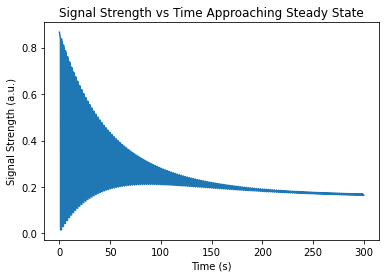

In [41]:
dx = 0.01
dy = 0.0025
dz = 0.02
flow_rate = 1.6
spin_grid = SpinGrid(.1, .1, .1, flow_rate, [-.1, .1], dx, dy, dz)

# setup the coil for testing
spin_grid.gen_save_coils(0,0)
spin_grid.setup_coil_for_test(0) 
spin_grid.compute_off_resonance_from_preset_coil()

dt = 4e-6
t1 = 1435e-3
t2 = 181e-3
TR = 6e-3
TE = 1.5e-3
theta = 60

no_points = int(TR/dt)
rf = np.zeros((no_points,))

rf[0] = theta/360/(4257*dt) # initial rf 
rf_inv = np.copy(rf)*-1 # invert the rf pulse
rf_both = np.vstack((rf,rf_inv)) # concatenate the rf pulse with its inverse
g = np.zeros((2,no_points))


signal = np.array([])

# Parameters to simulate
n_TRs_steady_state = 300
n_TRs_coil = 300
n_inner_loop = 10
bitrate = 4 / (n_TRs_coil * TR)

test_mag_x, test_mag_y, test_mag_z = 0, 0, 1

#put the spins into steady state
for i in range(n_TRs_steady_state):
    mx, my, mz = spin_grid.get_all_magnetizations()
    new_mx,new_my,new_mz = bloch(rf_both[i%2], g, dt, t1, t2, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
    spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])
    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

    test_mag_x_l, test_mag_y_l, test_mag_z_l = test_mag_x, test_mag_y, test_mag_z
    test_mag_x, test_mag_y, test_mag_z = bloch(rf_both[i%2], g, dt, t1, t2, 0, 0, 0, np.array([test_mag_x]), np.array([test_mag_y]), np.array([test_mag_z]))

test_mag_starts = [test_mag_x, test_mag_y, test_mag_z]

spin_grid_steady_state = copy.deepcopy(spin_grid)

# plot the magnetization of the spins as it approaches steady state, give the plot a title and axis labels
plt.figure()
plt.plot(dt*np.array(range(len(signal))) / TR, np.abs(signal))
plt.title("Signal Strength vs Time Approaching Steady State")
plt.xlabel("Time (s)")
plt.ylabel("Signal Strength")

# define a folder to save BSSFP images to with T1/T2/dx/dy/dz values in the name
folder = "BSSFP_Images/p2p_investigation_T12_" + str(t1) + "_" + str(t2) + "_dxyz_" + str(dx) + "_" + str(dy) + "_" + str(dz) + "/"

# create the folder
if not os.path.exists(folder):
    os.makedirs(folder)

# save the signal strength plot to the folder
plt.savefig(folder + "signal_strength_approaching_SS.png")

# save the signal strength data to the folder
np.savetxt(folder + "signal_strength_approaching_SS.txt", np.abs(signal))

def simulate_with_flow(
        n_TRs_coil=n_TRs_coil, 
        n_inner_loop=n_inner_loop, 
        bitrate=bitrate, dt=dt, 
        test_mag_starts=test_mag_starts,
        flow_rate=flow_rate
        ):
    """
        Simulate the signal with flow.
        Inputs:
            n_TRs_coil: number of TRs to simulate
            n_inner_loop: number of inner loops to simulate (per TR, how many discrete steps of flow to calculate)
            bitrate: bitrate of the flow (Hz)
            dt: timestep of the simulation (s)
            test_mag_starts: starting magnetization in steadystate of the test magnetization
            flow_rate: flow rate of the flow (cm/s)
    """
    signal = np.array([])

    # Reset the spin grid to be at the end of the steady state part of the simulation
    spin_grid = copy.deepcopy(spin_grid_steady_state)

    # generate a bit sequence of oscillating 1 and 0 values based on bitrate passed in (Hz)
    bit_sequence = np.zeros(n_TRs_coil)
    # Based off bitrate, set 1s and 0s for the bitsequence
    samples_per_bit = int(1/(bitrate * TR))
    for i in range(n_TRs_coil//samples_per_bit):
        bit_sequence[i*samples_per_bit:(i+1)*samples_per_bit] = i % 2 == 0

    # set flow rate
    spin_grid.flow_rate = flow_rate

    # bit_sequence = np.concatenate((np.ones(50), np.zeros(50), np.ones(50), np.zeros(50)))
    # modulate a bit sequence
    for i in range(n_TRs_coil):
        if i % 100 == 0:
            print("percent done: ", round(i/n_TRs_coil, 2)*100, "%")

        n_samples_inner = int(len(rf) / n_inner_loop)

        for j in range(n_inner_loop):
            # Flow the grid
            spin_grid.simulate_flow(TR/n_inner_loop, new_magnetization=np.array(test_mag_starts))

            mx, my, mz = spin_grid.get_all_magnetizations()
                
            # Note output of bloch is (offresonance x positions x time) for each magnetization
            new_mx,new_my,new_mz = bloch(rf_both[i%2][j*n_samples_inner:(j+1)*n_samples_inner], np.zeros((1, n_samples_inner)), dt, t1, t2, bit_sequence[i] * spin_grid.df * (-1)**i, 0, 2, mx, my, mz)
            test_mag_starts = bloch(rf_both[i%2][j*n_samples_inner:(j+1)*n_samples_inner], np.zeros((1, n_samples_inner)), dt, t1, t2, 0, 0, 0, np.array([test_mag_starts[0]]), np.array([test_mag_starts[1]]), np.array([test_mag_starts[2]]))

            spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])

            current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
            signal = np.append(signal, current_signal)

    signal_strength = np.abs(signal) / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z)

    # plot the magnetization of the spins as the coil dephases it, give the plot a title and axis labels
    # include information about the parameters of the simulation in the title
    plt.figure()
    plt.plot(dt*np.array(range(len(signal_strength))) / TR + n_TRs_steady_state, signal_strength)
    plt.title(f"Signal Strength vs Time with Flow Rate: {str(flow_rate)} cm/s, BitRate: {bitrate:.2f} b/s")
    plt.xlabel("TRs")
    plt.ylabel("Signal Strength")

    # save the signal to a file in the previously defined folder
    np.savetxt(folder + "signal_strength_flow_rate_" + str(flow_rate) + f"_bitrate_{bitrate:.2f}", signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

    plt.figure()
    signal_per_TR = signal_strength[int(TE/dt)::int(TR/dt)]
    plt.plot(np.array(range(len(signal_per_TR))) + n_TRs_steady_state, signal_per_TR)
    plt.title(f"Downsampled Signal Strength vs TR with Flow Rate: {str(flow_rate)} cm/s, BitRate: {bitrate:.2f} b/s")
    plt.xlabel("TRs")
    plt.ylabel("Signal Strength")
    # NOTE: make sure that the limits are set accordingly
    plt.ylim(.05, .18)

    # save the downsampled plot image to the previously defined folder
    plt.savefig(folder + "signal_strength_flow_rate_" + str(flow_rate) + f"_bitrate_{bitrate:.2f}" + "_TEsampled.png")

    # calculate peak to peak amplitude of the signal in the second half of signal
    ptp = np.ptp(signal_per_TR[len(signal_per_TR)//2:])

    # calculate max signal strength in the second half of signal
    max_signal = np.max(signal_per_TR[len(signal_per_TR)//2:])

    # calculate min signal strength in the second half of signal
    min_signal = np.min(signal_per_TR[len(signal_per_TR)//2:])
    return ptp, max_signal, min_signal


#### Running Various Flow Rates with 

running flowrate:  0  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.005  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.01  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.02  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.03  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.04  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.05  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.1  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.2  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  0.5  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  1  cm/s
percent done:  0.0 %
percent done:  50.0 %


/tmp/ipykernel_78336/2695974540.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


running flowrate:  2  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  5  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  10  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  20  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  50  cm/s
percent done:  0.0 %
percent done:  50.0 %
running flowrate:  100  cm/s
percent done:  0.0 %
percent done:  50.0 %


ValueError: x and y must have same first dimension, but have shapes (17,) and (1,)

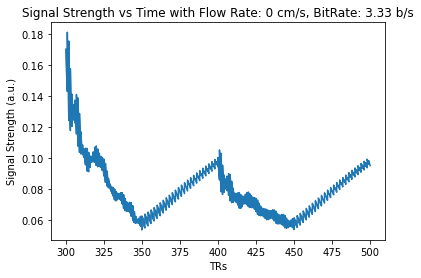

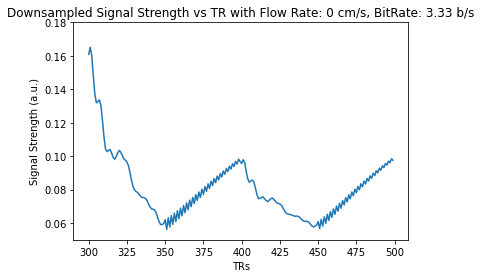

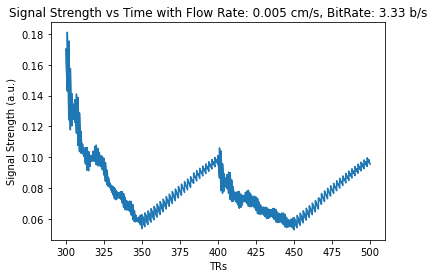

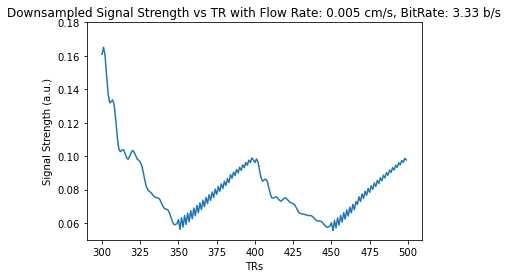

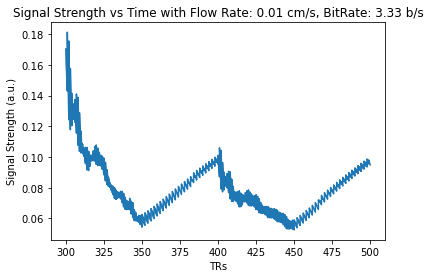

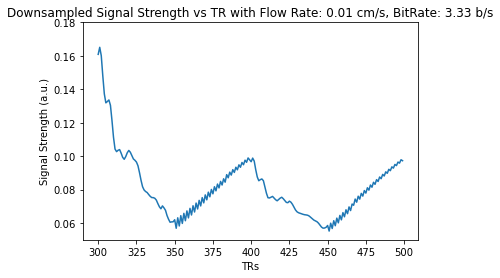

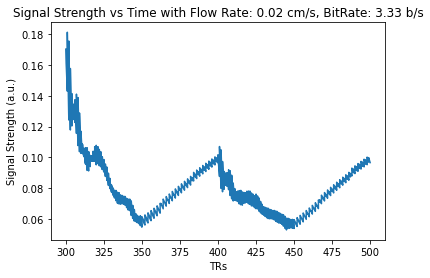

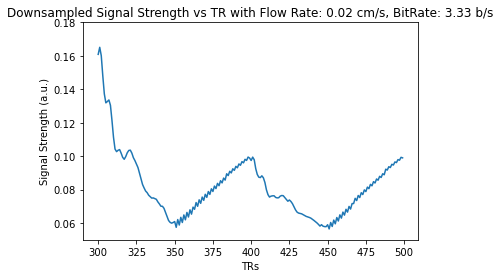

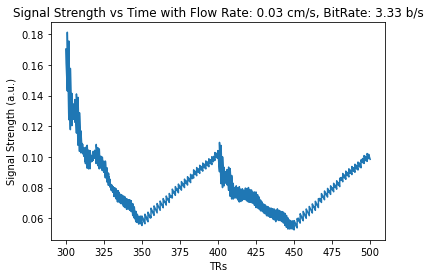

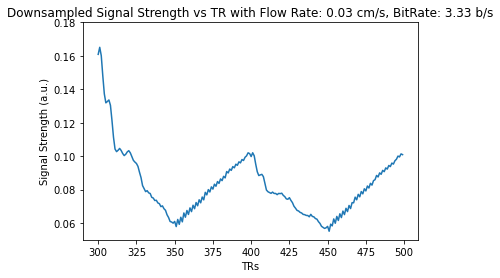

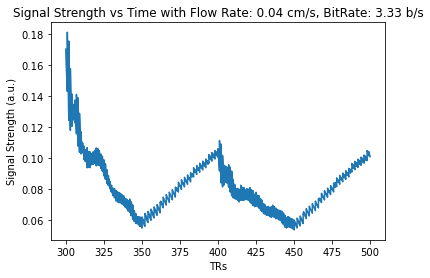

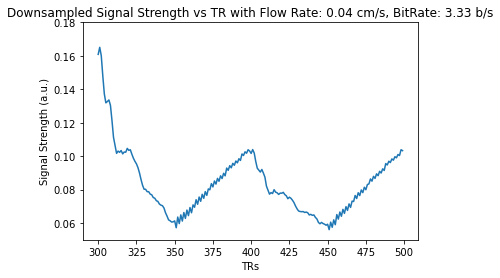

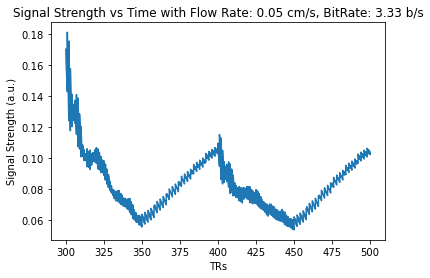

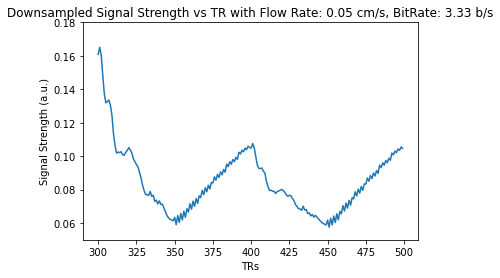

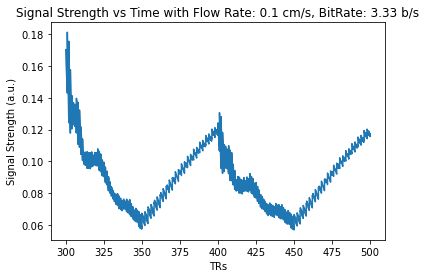

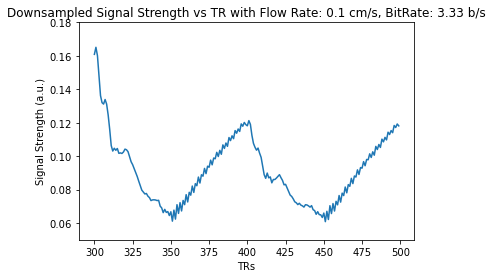

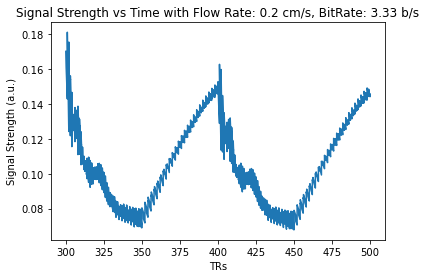

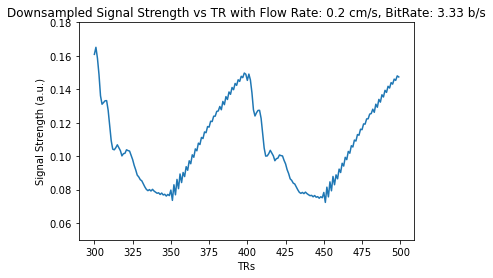

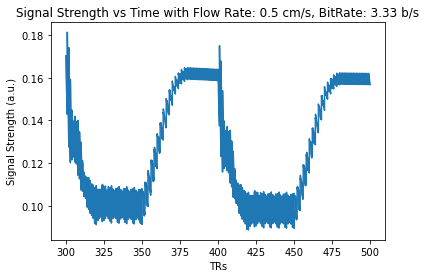

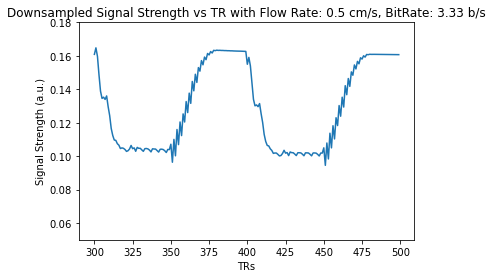

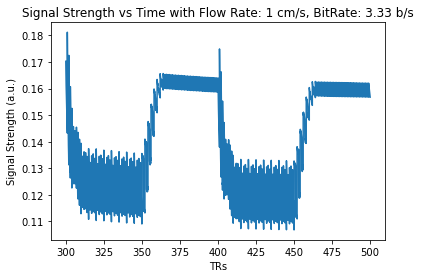

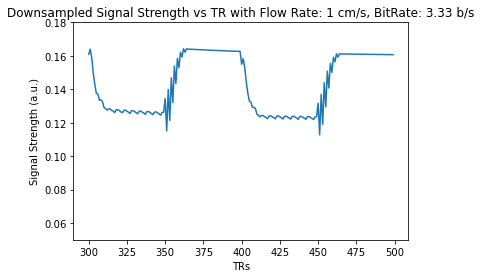

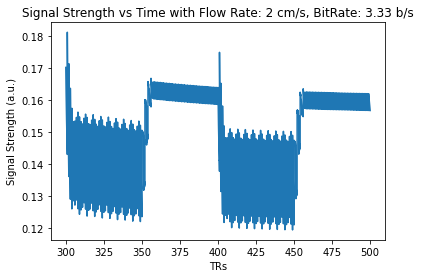

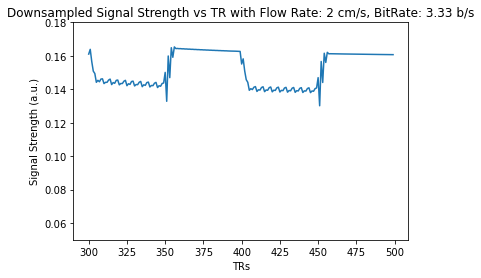

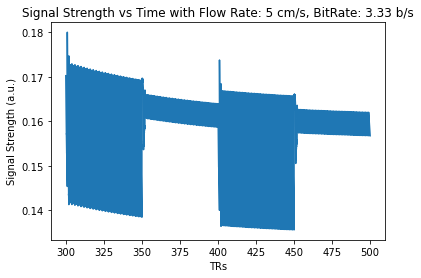

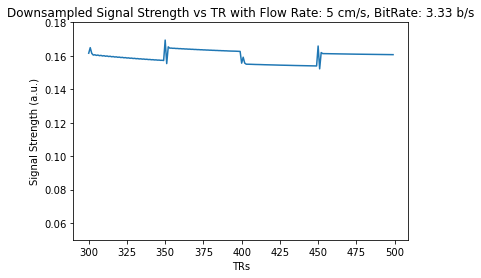

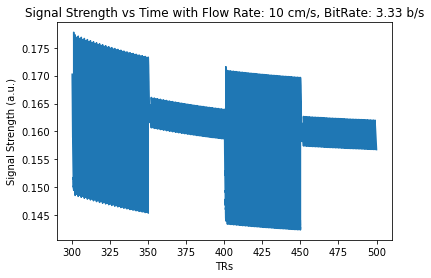

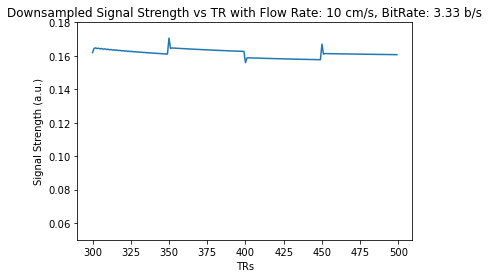

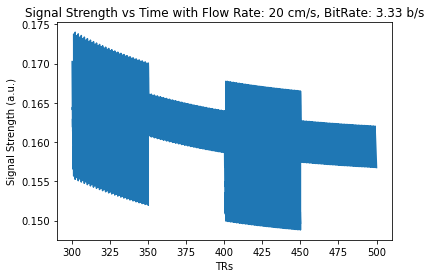

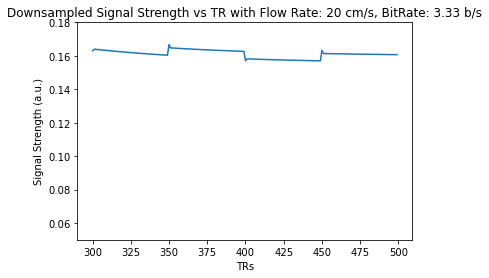

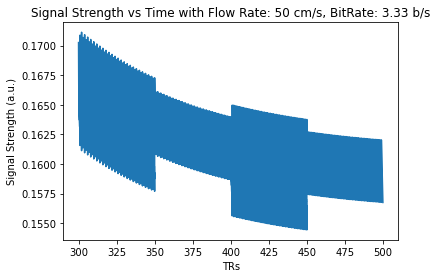

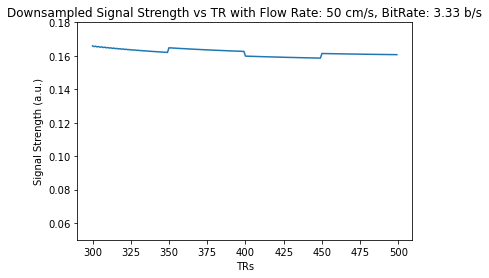

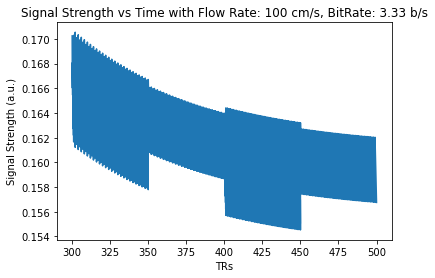

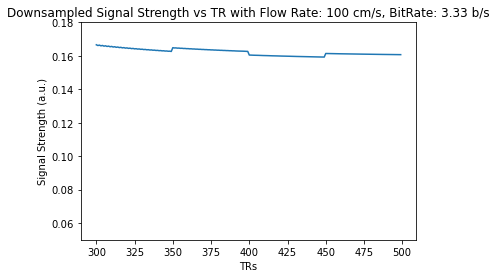

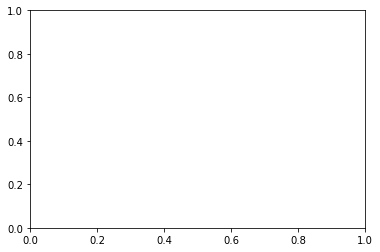

In [43]:
flowrates = [0, 0.005, 0.01, 0.02, .03, .04, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
p2ps = []
maxes = []
mins = []
for rate in flowrates:
    print("running flowrate: ", rate, " cm/s")
    p2p, ma, mi = simulate_with_flow(flow_rate=rate)
    p2ps.append(p2p)
    maxes.append(ma)
    mins.append(mi)


In [ ]:
# plot p2p vs flow rate
plt.figure()
plt.xscale("log")
plt.plot(flowrates, p2ps)
plt.title("Peak to Peak Amplitude vs Flow Rate")
plt.xlabel("Flow Rate (cm/s)")
plt.ylabel("Peak to Peak Amplitude")

# plot the max and min 
plt.figure()
plt.xscale("log")
plt.plot(flowrates, maxes, label="max")
plt.plot(flowrates, mins, label="min")
plt.title("Max and Min Signal Strength vs Flow Rate")
plt.xlabel("Flow Rate (cm/s)")
plt.ylabel("Signal Strength")
plt.legend()
plt.ylim(.05, .18)


# save the plot image and data to the previously defined folder
np.savetxt(folder + "p2p_vs_flow_rate", p2ps)
plt.savefig(folder + "p2p_vs_flow_rate.png")

# save the max min plot and data to the previously defined folder
np.savetxt(folder + "max_vs_flow_rate", maxes)
np.savetxt(folder + "min_vs_flow_rate", mins)
plt.savefig(folder + "maxmin_vs_flow_rate.png")


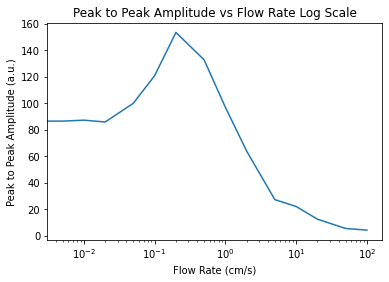

In [40]:
plt.figure()
plt.xscale("log")
plt.plot(flowrates, p2p)
plt.title("Peak to Peak Amplitude vs Flow Rate Log Scale")
plt.xlabel("Flow Rate (cm/s)")
plt.ylabel("Peak to Peak Amplitude")

# save the plot image and data to the previously defined folder
np.savetxt(folder + "p2p_vs_flow_rate_log", p2p)
plt.savefig(folder + "p2p_vs_flow_rate_log.png")

### Setting up TR Modulation Tests for BSSFP Sequences

running TR:  2.0  ms
running TR:  3.0  ms
running TR:  4.0  ms


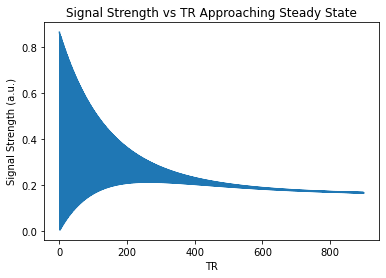

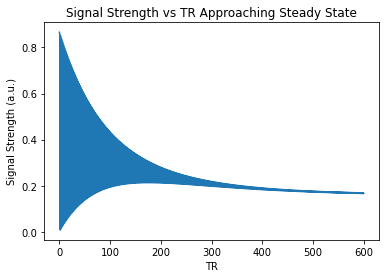

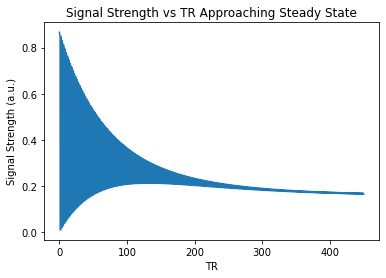

In [48]:
dx = 0.01
dy = 0.0025
dz = 0.02

flow_rate = 1

# setup the coil for testing
spin_grid.gen_save_coils(0,0)
spin_grid.setup_coil_for_test(0) 
spin_grid.compute_off_resonance_from_preset_coil()

dt = 4e-6
t1 = 1435e-3
t2 = 181e-3
theta = 60

# define a folder to save BSSFP images to with T1/T2/dx/dy/dz values in the name
folder = "BSSFP_Images/TRs_dxyz_" + str(dx) + "_" + str(dy) + "_" + str(dz) + "/"

# create the folder
if not os.path.exists(folder):
    os.makedirs(folder)


#____run simulation with flow____#
TRs = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10]) * 1e-3
p2p = []
mins = []
maxes = []

for i in range(len(TRs)):
    print("running TR: ", TRs[i]*1e3, " ms")
    spin_grid = SpinGrid(.1, .1, .1, flow_rate, [-.1, .1], dx, dy, dz)

    TR = TRs[i]
    TE = TR/4

    no_points = int(TR/dt)
    rf = np.zeros((no_points,))

    rf[0] = theta/360/(4257*dt) # initial rf 
    rf_inv = np.copy(rf)*-1 # invert the rf pulse
    rf_both = np.vstack((rf,rf_inv)) # concatenate the rf pulse with its inverse
    g = np.zeros((2,no_points))

    signal = np.array([])

    
    n_TRs_steady_state = int(1800 / int(TR*1e3))
    n_TRs_coil = int(200*6 / int(TR*1e3))
    n_inner_loop = 25
    bitrate = 4 / (n_TRs_coil * TR)

    test_mag_x, test_mag_y, test_mag_z = 0, 0, 1

    #put the spins into steady state
    for i in range(n_TRs_steady_state):
        mx, my, mz = spin_grid.get_all_magnetizations()
        new_mx,new_my,new_mz = bloch(rf_both[i%2], g, dt, t1, t2, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
        spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])
        current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
        signal = np.append(signal, current_signal / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

        test_mag_x_l, test_mag_y_l, test_mag_z_l = test_mag_x, test_mag_y, test_mag_z
        test_mag_x, test_mag_y, test_mag_z = bloch(rf_both[i%2], g, dt, t1, t2, 0, 0, 0, np.array([test_mag_x]), np.array([test_mag_y]), np.array([test_mag_z]))

    test_mag_starts = [test_mag_x, test_mag_y, test_mag_z]

    spin_grid_steady_state = copy.deepcopy(spin_grid)

    # plot the magnetization of the spins as it approaches steady state, give the plot a title and axis labels
    plt.figure()
    plt.plot(dt*np.array(range(len(signal))) / TR, np.abs(signal))
    plt.title(f"Signal vs TR Count (TR = {TR*1e3} ms)")
    plt.xlabel("TR")
    plt.ylabel("Signal Strength")

    # save the signal strength plot and data to the folder
    plt.savefig(folder + f"signal_strength_approaching_SS_TR_{TR*1e3}.png")
    np.savetxt(folder + f"signal_strength_approaching_SS_TR_{TR*1e3}.txt", np.abs(signal))

    
    

# # plot p2p vs TR
# plt.figure()
# plt.plot(flowrates, p2p)
# plt.title("Peak to Peak Amplitude vs TR | Flow Rate: 03 cm/s")
# plt.xlabel("Flow Rate (cm/s)")
# plt.ylabel("Peak to Peak Amplitude")

# # save the plot image and data to the previously defined folder
# np.savetxt(folder + "p2p_vs_flow_rate", p2p)
# plt.savefig(folder + "p2p_vs_flow_rate.png")

#### Gen BZ from coil at desired positions

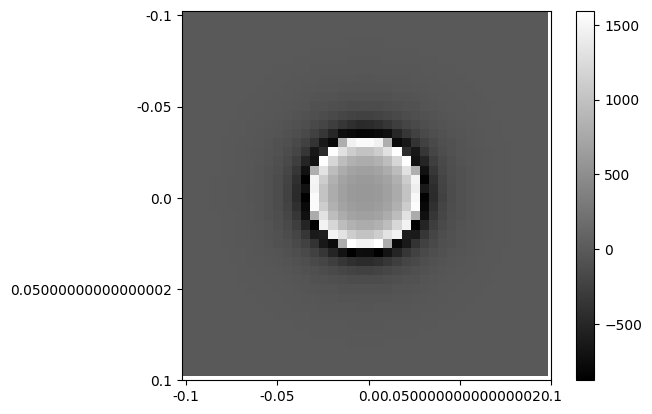

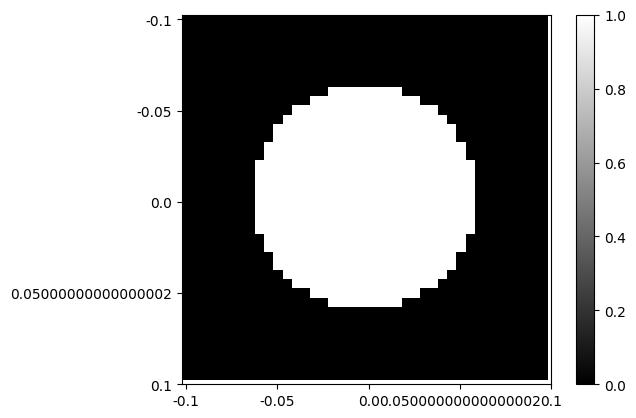

In [ ]:
spin_grid.gen_save_coils(0,0)
spin_grid.compute_off_resonance_from_coil(9) 

freq_grid = spin_grid.df.reshape((spin_grid.n_spins_y, spin_grid.n_spins_x, spin_grid.n_spins_z))

#for i in range(spin_grid.n_spins_z):
for i in [spin_grid.n_spins_z//2]:
    plt.figure()
    plt.imshow(freq_grid[:, :, i], cmap="gray")
    # Relabel axes to be from -spin_grid.width / 2 to spin_grid.width / 2
    plt.xticks(np.linspace(0, spin_grid.n_spins_x, 5), np.linspace(-spin_grid.width/2, spin_grid.width/2, 5))
    plt.yticks(np.linspace(0, spin_grid.n_spins_y, 5), np.linspace(-spin_grid.height/2, spin_grid.height/2, 5))
    # Add a colorbar legend 
    plt.colorbar()


# add another heatmap, but this time all frequencies less than a threshold are set to 0
plt.figure()
plt.imshow(np.abs(freq_grid[:, :, spin_grid.n_spins_z//2]) > 50, cmap="gray")
plt.xticks(np.linspace(0, spin_grid.n_spins_x, 5), np.linspace(-spin_grid.width/2, spin_grid.width/2, 5))
plt.yticks(np.linspace(0, spin_grid.n_spins_y, 5), np.linspace(-spin_grid.height/2, spin_grid.height/2, 5))
plt.colorbar()

### Create a basic sequence. 
This will correspond to: b1 (rf) [1 x M], gr (2xM), and readout_indices

In [ ]:
def create_ssfp_rf(dt, TR, theta=60):
    """
        Creates an RF pulse for a single TR of the ssfp sequence. TR_index 
        is included in case we want to change the angle depending on the TR. 
    """
    # Create an empty sequence, then calculate the magnitude of a single sample 
    # hard RF pulse to rotate by theta degrees 
    rf_seq = np.zeros(int(TR/dt))
    rf_mag = theta/360/(4257*dt)

    # Add in the magnitude to the first sample then return
    rf_seq[0] = rf_mag
    return rf_seq 


def create_ssfp_sequence(TR, dt, theta=60):
    """
        Create a single TR of an SSFP sequence that just does a single theta degree 
        RF pulse. 

        Returns rf_seq, grad_seq  
    """
    # Create the rf sequence 
    rf_seq = create_ssfp_rf(dt, TR, theta=theta)

    # Create the gradient sequence
    gx = 0 * rf_seq
    gy = 0 * rf_seq 
    grad_seq = np.vstack((gx, gy))

    return rf_seq, grad_seq


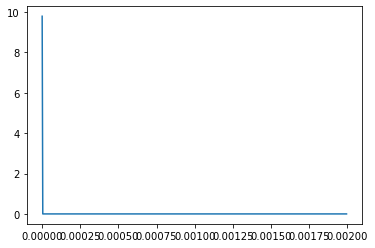

In [ ]:
# Create a single TR of the sequence and plot the RF pulse
TR = 2e-3 
dt = 4e-6
rf_seq, grad_seq = create_ssfp_sequence(TR, dt)

# Plot the RF pulse
plt.plot(dt * np.array(range(len(rf_seq))), rf_seq)

### Simulate the sequence 

In [ ]:
# Define all of the parameters for the simulation 
TR = 10e-3 # 2e-3 
dt = 4e-6
n_TRs = 200
T1 = 200e-3 # 0.83 
T2 = 100e-3 # 0.08
theta = 90

# Try creating a SpinGrid
spin_grid = SpinGrid(10, 10, 5, [-2, 2], 0.5, 0.5)
#spin_grid.visualize_grid()

# Simulate forward through n_TRs, keeping track of the magnetizations at every point in time. 
signal = np.array([])

for i in range(n_TRs):
    # Get the rf and gradient sequence for this TR 
    rf_seq, grad_seq = create_ssfp_sequence(TR, dt, theta=theta)

    # On odd TRs, flip the sign of the rf sequence 
    if i % 2 == 1:
        rf_seq = -rf_seq

    mx, my, mz = spin_grid.get_all_magnetizations() 
    positions = spin_grid.get_all_positions()
    df = 0

    new_mx, new_my, new_mz = bloch(rf_seq, grad_seq, dt, T1, T2, df, positions, 2, mx, my, mz) # magnetizations are num_positions x num_times if no off resonance frequency 
    spin_grid.set_all_magnetizations(new_mx[:, -1], new_my[:, -1], new_mz[:, -1])

    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)

signal_strength = np.abs(signal)

TypeError: SpinGrid.__init__() missing 2 required positional arguments: 'delta_y' and 'delta_z'

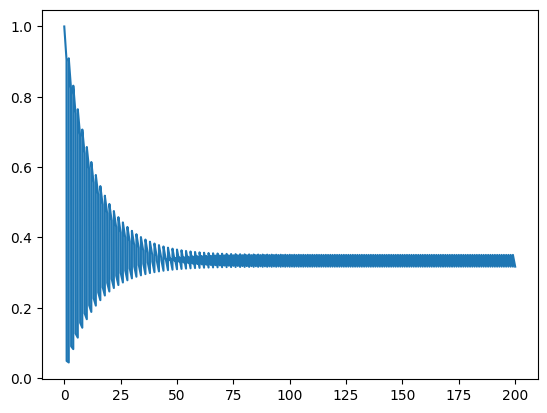

In [ ]:
plt.plot(dt*np.array(range(len(signal_strength))) / TR, signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y))


### Perform Sim With Coil
##### No gradient, No movement, No problams, tho offresonance
##### we will just integrate signal within the voxel --> our spins will only be the grid inside of the voxel that we care about

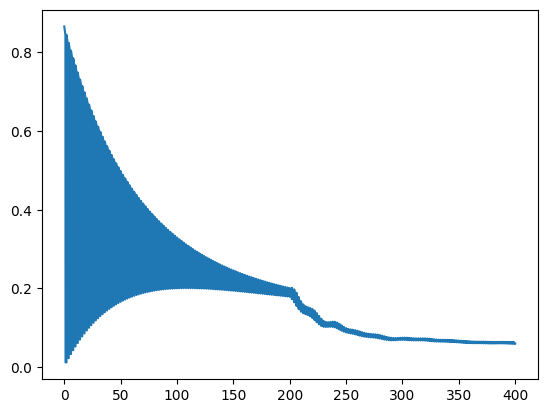

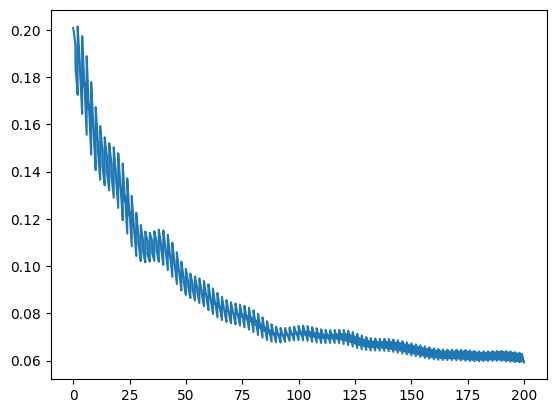

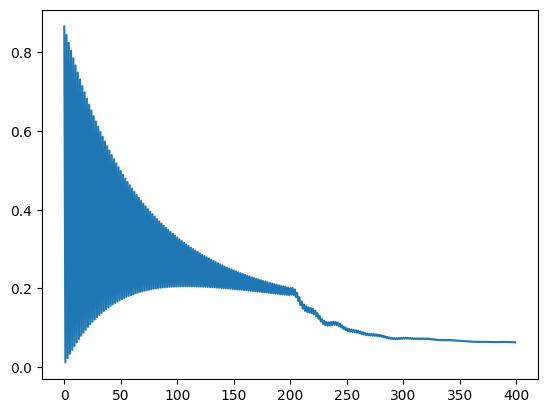

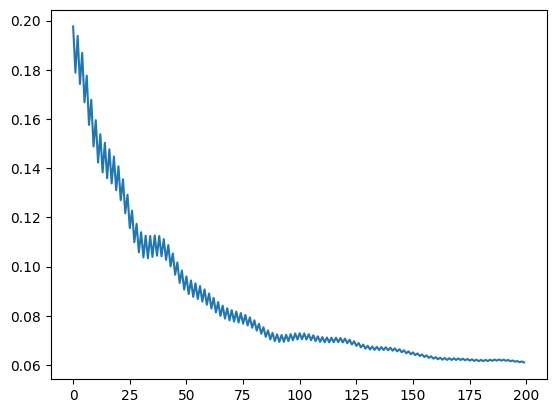

In [ ]:
%matplotlib inline
spin_grid = SpinGrid(.1, .1, 0.1, 0, [-.1, .1], 0.01, 0.01, 0.01)

spin_grid.gen_save_coils(0,0)
spin_grid.compute_off_resonance_from_coil(0) 

dt = 4e-6
t1 = 0.832
t2 = 0.08
TR = 2e-3
TE = 1e-3

theta = 60

no_points = int(TR/dt)
rf = np.zeros((no_points,))

rf[0] = theta/360/(4257*dt) # initial rf 
rf_inv = np.copy(rf)*-1 # invert the rf pulse
rf_both = np.vstack((rf,rf_inv)) # concatenate the rf pulse with its inverse
g = np.zeros((2,no_points))


signal = np.array([])

# Parameters to simulate
n_TRs_steady_state = 200
n_TRs_coil = 200

#put the spins into steady state
for i in range(n_TRs_steady_state):
    mx, my, mz = spin_grid.get_all_magnetizations()
    new_mx,new_my,new_mz = bloch(rf_both[i%2], g, dt, t1, t2, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
    spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])
    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)


for i in range(n_TRs_coil):
    # Initialize based on the grid 
    mx, my, mz = spin_grid.get_all_magnetizations()

    # Note output of bloch is (offresonance x positions x time) for each magnetization
    new_mx,new_my,new_mz = bloch(rf_both[i%2], g, dt, t1, t2, (-1)**(i) * spin_grid.df, 0, 2, mx, my, mz)
    
    # Update the magnetizations in the grid
    spin_grid.set_all_magnetizations(new_mx[:,-1], new_my[:,-1], new_mz[:,-1])

    # Track the signal we received 
    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)

signal_strength = np.abs(signal)

signal_secondhalf = signal_strength[len(signal_strength)//2:]

plt.plot(dt*np.array(range(len(signal_strength))) / TR, signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

plt.figure() 
plt.plot(dt*np.array(range(len(signal_secondhalf))) / TR, signal_secondhalf / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

plt.figure()
TR_subsample_signal = signal_strength[::int(TR/dt)]
plt.plot(range(len(TR_subsample_signal)), TR_subsample_signal / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

plt.figure() 
TR_subsample_secondhalf = signal_secondhalf[int(TE/dt)::int(TR/dt)]
plt.plot(range(len(TR_subsample_secondhalf)), TR_subsample_secondhalf / (spin_grid.n_spins_x*spin_grid.n_spins_y*spin_grid.n_spins_z))

### 2D BSSFP Simulation and Acquisition

In [ ]:
# Helper functions
from tqdm import tqdm as tqdm

def myfft2c(f):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(f)))

def myifft2c(F):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(F)))

def crop(im, Np, Nf):
    [my,mx] = im.shape;
    idxy = np.linspace(my/2 - Np/2, my/2 + Np/2-1,Np).astype('int')
    idxx = np.linspace(mx/2 - Nf/2, mx/2 + Nf/2-1,Nf).astype('int')

    res = im[:,idxx]
    res = res[idxy,:]
    return res

def imshow(img, vmin=None, vmax=None, fig=None, figsize=(8,8)):
    if fig is None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off');
    return None

In [ ]:
# More Helper functions
def minimum_time_gradient(area, max_gradient, slew_rate, dt):
    """
    Returns minimum time gradient waveform for given parameters.
    """    
    triangle_area = max_gradient**2 / slew_rate

    if area <= triangle_area:
        print('Triangle')
        t1 = np.sqrt(area / slew_rate)
        T = 2 * t1
        N = int(np.floor(T/dt))
        t = np.arange(1, N+1) * dt

        idx1 = np.where(t <= t1)
        idx2 = np.where(t >= t1)

        g = np.zeros(N)
        g[idx1] = slew_rate * t[idx1]
        g[idx2] = 2 * np.sqrt(area * slew_rate) - slew_rate * t[idx2]

    else:
        print('Trapezoid')
        t1 = max_gradient / slew_rate
        t2 = area / max_gradient
        t3 = area / max_gradient + (max_gradient / slew_rate)

        T = t3
        N = int(np.floor(T/dt))
        t = np.arange(1, N+1) * dt

        idx1 = np.where(t <= t1)
        idx2 = np.where((t>=t1) & (t <= t2))
        idx3 = np.where(t>=t2)

        g = np.zeros(N)
        g[idx1] = slew_rate * t[idx1]
        g[idx2] = max_gradient
        g[idx3] = (area/max_gradient + max_gradient/slew_rate) * slew_rate - slew_rate * t[idx3]

    print('Maximum gradient: {:.3f} G/cm'.format(np.max(g)))
    print('Duration: {:.3f} ms'.format(t[-1]*1e3))
    return g

def gen_readout_gradient(Nf, FOVr, bwpp, Gmax, Smax, dt):

    gamma_bar = 4258
    res = FOVr/Nf
    Wkx = 1/res
    area = Wkx/gamma_bar

    G = bwpp/res/gamma_bar
    Tro = Wkx/gamma_bar/G
    Tramp = G/Smax

    t1 = Tramp
    t2 = t1+Tro
    T = Tramp*2+Tro


    N = int(np.floor(T/dt))
    t = np.linspace(1,N,N)*dt

    idx1 = np.argwhere(t < t1)
    idx2 = np.argwhere((t>=t1) & (t < t2))
    idx3 = np.argwhere(t>=t2)

    gro = np.zeros((N))
    gro[idx1] = Smax*t[idx1]
    gro[idx2] = G;
    gro[idx3] = T*Smax - Smax*t[idx3]

    areaTrapz = (T+Tro)*G/2; # area of readout trapezoid
    gpre = minimum_time_gradient(areaTrapz/2, Gmax, Smax, dt)

    rowin = idx2
    
    return gro, gpre, rowin.ravel()



def gen_pe_gradient(Np, FOVp, Gmax, Smax, dt):

    gamma_bar = 4258

    kmax = 1/(FOVp/Np)/2
    area = kmax/gamma_bar
    grpe = minimum_time_gradient(area, Gmax, Smax, dt)

    petable = np.linspace(Np/2-0.5,-Np/2+0.5,Np)/(Np/2)
    
    return grpe, petable


#### Setup Sim

In [ ]:
# Parameters for the SSFP sequence 
Nf = 19 # Number of points in readout     
Np = 19 # Number of phase encodes
Nrf = 1 # just do a single hit RF pulse 
FOVr = 2 # FOV in the readout direction
FOVp = 2 # FOV in the phase encode direction
Gmax = 4 # Maximum gradient amplitude
Smax = 15000 # Maximum slew-rate
dt = 4e-6 # Time interval between samples
bwpp = 1862.4 # Bandwidth per pixel
gamma = 4257
T1=100
T2=100
TR = 6e-3
TE = 1.5e-3
theta = 60

In [ ]:
# Generate waveforms and get stat data
gro, gpre, rowin = gen_readout_gradient(Nf, FOVr, bwpp, Gmax, Smax, dt)
gpe,petable = gen_pe_gradient(Np, FOVp, Gmax, Smax, dt)

print("TE: ", TE)

Trapezoid
Maximum gradient: 4.000 G/cm
Duration: 0.688 ms
Trapezoid
Maximum gradient: 4.000 G/cm
Duration: 0.544 ms
TE:  0.0015


In [ ]:
# Assemble the Gradient and Bfield waveforms

no_points = int(TR/dt)
rf = np.zeros((no_points,))
gx = np.zeros((no_points,))
gy = np.zeros((no_points,))

rf[0] = theta/360/(4257*dt) # initial rf 
rf_inv = np.copy(rf)*-1 # invert the rf pulse
rf_both = np.vstack((rf,rf_inv)) # concatenate the rf pulse with its inverse

gx[1:len(gpre)+1] = -gpre # prewinder in x 
gy[1:len(gpe)+1] = gpe # prewinder in y 
# Note: Make sure to cosine modulate the readouts after the acquisition.

TE_index = int(TE//dt) + 1
print(TE_index, len(gro))
gx[TE_index - int(len(gro)/2): TE_index - int(len(gro)/2) + len(gro)] = gro # readout gradient in x
grostartidx = TE_index - int(len(gro)/2) 

# add in rewinders since this is a bssfp pulse sequence

gx[2*TE_index-len(gpre):2*TE_index] = -gpre
gy[2*TE_index-len(gpe):2*TE_index] = -gpe

376 272


Text(0, 0.5, 'Gy')

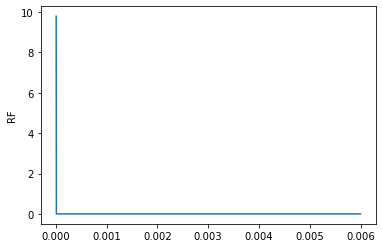

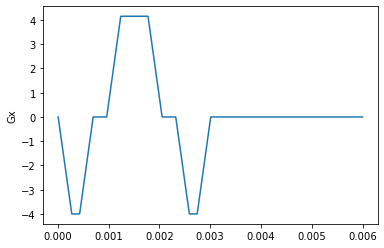

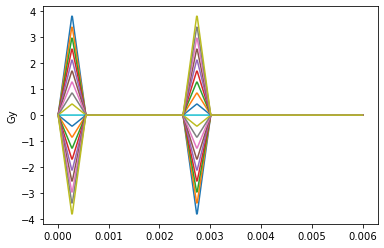

In [ ]:
plt.figure()
plt.plot(dt*np.linspace(1,no_points,no_points), rf)
plt.ylabel('RF')
plt.figure()
plt.plot(dt*np.linspace(1,no_points,no_points), gx)
plt.ylabel('Gx')
plt.figure()
for i in range(Np):
    plt.plot(dt*np.linspace(1,no_points,no_points), gy*(petable[i]))
plt.ylabel('Gy')

#### Perform Sim WITHOUT Coil

In [ ]:
mx, my, mz = spin_grid.get_all_magnetizations()

# concatenate the gradients into one array and call the Bloch simulator
print(np.vstack((gx, gy*petable[i])).shape)
print(spin_grid.get_all_positions().shape)
print(rf_both[0][None,:].shape)
mx_rf,my_rf,mz_rf = bloch(rf_both[0][None,:], np.vstack((gx, gy*petable[i])),dt,.5, .5,np.arange(5), spin_grid.get_all_positions(),2,mx,my,mz)
print(mx_rf.shape)

(2, 1500)
(2, 100)
(1, 1500)
(5, 100, 1500)


In [ ]:
#Note output of bloch is (offresonance x positions x time)
spin_grid = SpinGrid(FOVr/2, FOVp/2, 0, [-1, 1], 0.1, 0.1)

#put the spins into steady state
for i in range(200):
    mx, my, mz = spin_grid.get_all_magnetizations()
    mx_rf,my_rf,mz_rf = bloch(rf_both[i%2], rf_both*0, dt, spin_grid.T1_moving, spin_grid.T2_moving, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
    spin_grid.set_all_magnetizations(mx_rf[:,-1], my_rf[:,-1], mz_rf[:,-1])


# Output data matrix
ksp = np.zeros((Np, len(rowin)), dtype=np.complex64) # array for our k-space data


for i in range(Np):
    mx, my, mz = spin_grid.get_all_magnetizations()

    # concatenate the gradients into one array and call the Bloch simulator
    mx_rf,my_rf,mz_rf = bloch(rf_both[i%2], np.vstack((gx, gy*petable[i])), dt, spin_grid.T1_moving, spin_grid.T2_moving, 0, spin_grid.get_all_positions(), 2, mx, my, mz)

    spin_grid.set_all_magnetizations(mx_rf[:,-1], my_rf[:,-1], mz_rf[:,-1])
    # store the transverse magnetization during the readout portion in the result array
    ksp[i] = np.sum(mx_rf, 0)[rowin + grostartidx] + 1j*np.sum(my_rf, 0)[rowin + grostartidx]
    ksp[i] = ksp[i]*((-1)**i)
###

print('resulting data shape:', ksp.shape)

resulting data shape: (19, 134)


Text(0.5, 1.0, 'FOV=2.00x2.00cm$^2$. Res=0.11x0.11cm$^2$')

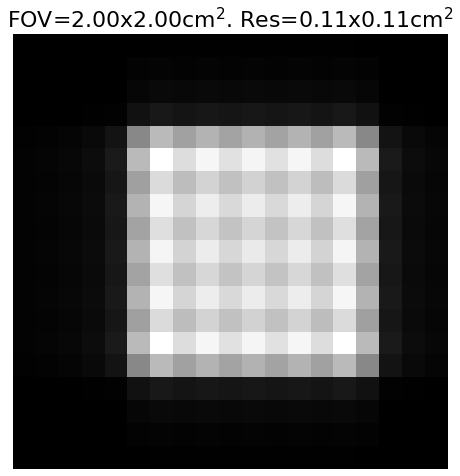

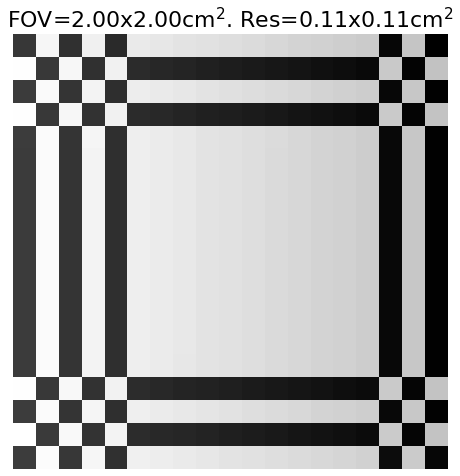

In [ ]:
# Reconstruct and plot magnitude/phase images

im = crop(myifft2c(ksp), Np, Nf)

fig = plt.figure(figsize=(8,8))
imshow(abs(im), fig=fig);
plt.title('FOV={:.2f}x{:.2f}cm$^2$. Res={:.2f}x{:.2f}cm$^2$'.format(FOVp, FOVr, FOVp/Np, FOVr/Nf), fontsize=22)
fig = plt.figure(figsize=(8,8))
imshow(np.angle(im), fig=fig);
plt.title('FOV={:.2f}x{:.2f}cm$^2$. Res={:.2f}x{:.2f}cm$^2$'.format(FOVp, FOVr, FOVp/Np, FOVr/Nf), fontsize=22)

In [ ]:
#Note output of bloch is (offresonance x positions x time)
spin_grid = SpinGrid(.1, .1, 0, [-.1, .1], 0.01, 0.01)

spin_grid.gen_save_coils(0,0)
spin_grid.compute_off_resonance_from_coil(9) 


#put the spins into steady state
for i in range(200):
    mx, my, mz = spin_grid.get_all_magnetizations()
    mx_rf,my_rf,mz_rf = bloch(rf_both[i%2], rf_both*0, dt, spin_grid.T1_moving, spin_grid.T2_moving, 0, spin_grid.get_all_positions(), 2, mx, my, mz)
    spin_grid.set_all_magnetizations(mx_rf[:,-1], my_rf[:,-1], mz_rf[:,-1])


# Output data matrix
ksp = np.zeros((Np, len(rowin)), dtype=np.complex64) # array for our k-space data


for i in range(Np):
    mx, my, mz = spin_grid.get_all_magnetizations()

    # concatenate the gradients into one array and call the Bloch simulator
    mx_rf,my_rf,mz_rf = bloch(rf_both[i%2], rf_both*0, dt, spin_grid.T1_moving, spin_grid.T2_moving, 0, spin_grid.get_all_positions(), 2, mx, my, mz)

    spin_grid.set_all_magnetizations(mx_rf[:,-1], my_rf[:,-1], mz_rf[:,-1])
    # store the transverse magnetization during the readout portion in the result array
    ksp[i] = np.sum(mx_rf, 0)[rowin + grostartidx] + 1j*np.sum(my_rf, 0)[rowin + grostartidx]
    ksp[i] = ksp[i]*((-1)**i)
###

print('resulting data shape:', ksp.shape)

In [ ]:
# Reconstruct and plot magnitude/phase images

im = crop(myifft2c(ksp), Np, Nf)

fig = plt.figure(figsize=(8,8))
imshow(abs(im), fig=fig);
plt.title('FOV={:.2f}x{:.2f}cm$^2$. Res={:.2f}x{:.2f}cm$^2$'.format(FOVp, FOVr, FOVp/Np, FOVr/Nf), fontsize=22)
plt.colorbar()
fig = plt.figure(figsize=(8,8))
imshow(np.angle(im), fig=fig);
plt.title('FOV={:.2f}x{:.2f}cm$^2$. Res={:.2f}x{:.2f}cm$^2$'.format(FOVp, FOVr, FOVp/Np, FOVr/Nf), fontsize=22)
plt.colorbar()

# Miscelaneous


In [ ]:
?bloch

Signature: bloch(b1, gr, tp, t1, t2, df, dp, mode, mx=None, my=None, mz=None)
Docstring:
Bloch simulation of rotations due to B1, gradient and
off-resonance, including relaxation effects.  At each time
point, the rotation matrix and decay matrix are calculated.
Simulation can simulate the steady-state if the sequence
is applied repeatedly, or the magnetization starting at m0.

INPUT:
        b1 = (1xM) RF pulse in G.  Can be complex.
        gr = ((1,2,or 3)xM) 1,2 or 3-dimensional gradient in G/cm.
        tp = (1xM) time duration of each b1 and gr point, in seconds,
                        or 1x1 time step if constant for all points
                        or monotonically INCREASING endtime of each
                        interval..
        t1 = T1 relaxation time in seconds.
        t2 = T2 relaxation time in seconds.
        df = (1xN) Array of off-resonance frequencies (Hz)
        dp = ((1,2,or 3)xP) Array of spatial positions (cm).
                Width should match width of gr

In [ ]:
# # Create an animation of the grid flowing 
# flow_dt = 0.005
# fig, ax = plt.subplots()

# def update(frame):
#     plt.gca().clear()
#     spin_grid.simulate_flow(flow_dt)
#     spin_grid.visualize_grid()
#     return plt.gca()

# anim = FuncAnimation(fig, update, frames=range(3))
# HTML(anim.to_jshtml())
# anim.save("./temp.gif", writer='imagemagick', fps=15)